Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures

In [2]:
application_train = pd.read_csv(r'C:\Users\HP\Desktop\Credit_risk\application_train.csv')
application_test = pd.read_csv(r'C:\Users\HP\Desktop\Credit_risk\application_test.csv')
bureau = pd.read_csv(r'C:\Users\HP\Desktop\Credit_risk\bureau.csv')
bureau_balance = pd.read_csv(r'C:\Users\HP\Desktop\Credit_risk\bureau_balance.csv')
POS_CASH_balance = pd.read_csv(r'C:\Users\HP\Desktop\Credit_risk\POS_CASH_balance.csv')
credit_card_balance = pd.read_csv(r'C:\Users\HP\Desktop\Credit_risk\credit_card_balance.csv')
previous_application = pd.read_csv(r'C:\Users\HP\Desktop\Credit_risk\previous_application.csv')
installments_payments = pd.read_csv(r'C:\Users\HP\Desktop\Credit_risk\installments_payments.csv')

In [3]:
print(application_train.head())
print(application_train.info())
print(application_test.info())
print(bureau.info())
print(bureau_balance.info())
print(POS_CASH_balance.info())
print(credit_card_balance.info())
print(previous_application.info())
print(installments_payments.info())


   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0             

Data Preprocessing

In [4]:
# Preprocess data: handle missing values and one-hot encode categorical variables
def preprocess_data(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())
    df = pd.get_dummies(df)
    return df


In [5]:
# Separate and preprocess datasets
train_target = application_train['TARGET']
application_train = preprocess_data(application_train.drop(columns=['TARGET']))
application_test = preprocess_data(application_test)
bureau = preprocess_data(bureau)
bureau_balance = preprocess_data(bureau_balance)
POS_CASH_balance = preprocess_data(POS_CASH_balance)
credit_card_balance = preprocess_data(credit_card_balance)
previous_application = preprocess_data(previous_application)
installments_payments = preprocess_data(installments_payments)
application_train, application_test = application_train.align(application_test, join='inner', axis=1)
application_train['TARGET'] = train_target


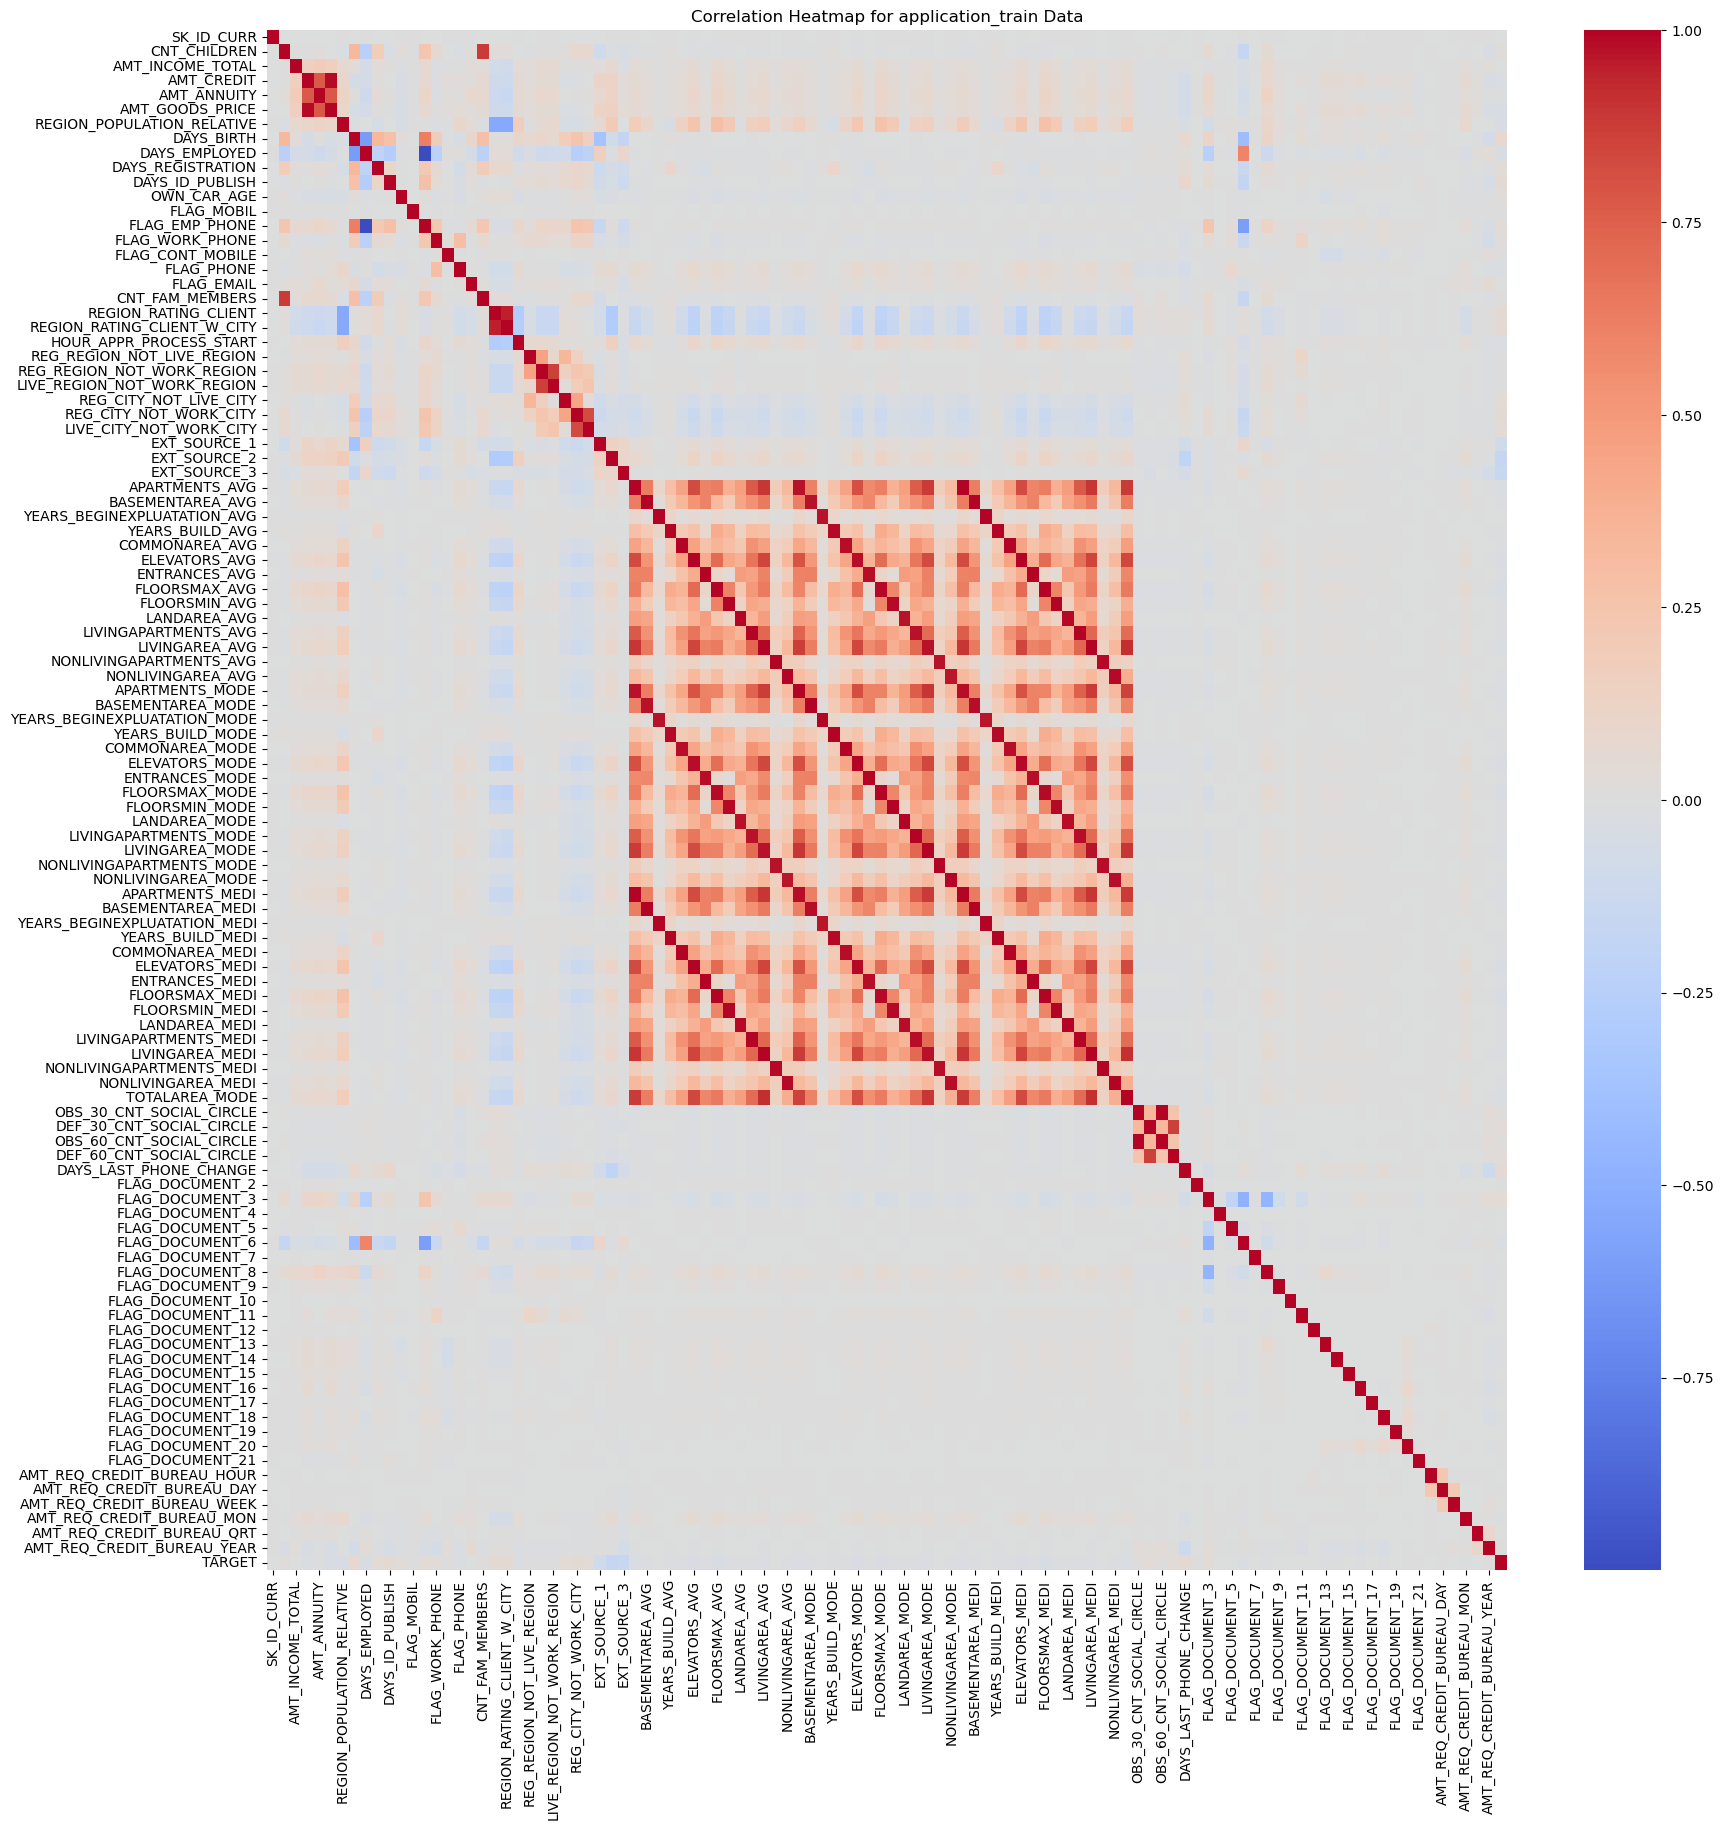

In [6]:
# Correlation Matrix for application_train Data
plt.figure(figsize=(20, 20))
numeric_columns = application_train.select_dtypes(include=['number']).columns
corr_matrix = application_train[numeric_columns].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap for application_train Data')
plt.show()


In [7]:
# Identify and drop highly correlated features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
application_train.drop(columns=to_drop, inplace=True)
application_test.drop(columns=to_drop, inplace=True)
print(f'Dropped {len(to_drop)} highly correlated features.')
print(application_train.shape)
print(application_test.shape)


Dropped 40 highly correlated features.
(307511, 203)
(48744, 202)


In [8]:
# Replace outliers with median values
def replace_outliers_with_median(df, numeric_columns, contamination=0.01):
    iso = IsolationForest(contamination=contamination, random_state=42)
    yhat = iso.fit_predict(df[numeric_columns])
    mask = yhat == -1
    print(f"Number of outliers detected: {sum(mask)}")
    for col in numeric_columns:
        median_value = df[col].median()
        df.loc[mask, col] = median_value
    return df

numeric_columns = application_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('TARGET')
application_train = replace_outliers_with_median(application_train, numeric_columns)
numeric_columns_test = application_test.select_dtypes(include=[np.number]).columns.tolist()
application_test = replace_outliers_with_median(application_test, numeric_columns_test)
print(application_train.describe())
print(application_test.describe())


Number of outliers detected: 3076
Number of outliers detected: 488
          SK_ID_CURR   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count  307511.000000  307511.000000      3.075110e+05  3.075110e+05   
mean   278161.544296       0.412759      1.673431e+05  5.952216e+05   
std    102221.439973       0.719485      2.360027e+05  3.970875e+05   
min    100002.000000       0.000000      2.565000e+04  4.500000e+04   
25%    190090.500000       0.000000      1.125000e+05  2.700000e+05   
50%    278202.000000       0.000000      1.471500e+05  5.135310e+05   
75%    366128.500000       1.000000      2.025000e+05  8.086500e+05   
max    456255.000000      19.000000      1.170000e+08  4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               307511.000000  307511.000000  307511.000000   
mean                     0.020627  -16034.036834   63025.205586   
std                      0.013439    4340.754719  140601.382952   
min                      

Feature Engineering

In [9]:
# Create new features with necessary checks
train_features = pd.DataFrame()
test_features = pd.DataFrame()

if 'AMT_CREDIT' in application_train.columns and 'AMT_INCOME_TOTAL' in application_train.columns:
    train_features['CREDIT_INCOME_RATIO'] = application_train['AMT_CREDIT'] / application_train['AMT_INCOME_TOTAL']
    test_features['CREDIT_INCOME_RATIO'] = application_test['AMT_CREDIT'] / application_test['AMT_INCOME_TOTAL']

if 'AMT_ANNUITY' in application_train.columns and 'AMT_INCOME_TOTAL' in application_train.columns:
    train_features['ANNUITY_INCOME_RATIO'] = application_train['AMT_ANNUITY'] / application_train['AMT_INCOME_TOTAL']
    test_features['ANNUITY_INCOME_RATIO'] = application_test['AMT_ANNUITY'] / application_test['AMT_INCOME_TOTAL']

if all(ext in application_train.columns for ext in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    train_features['EXT_SOURCE_MEAN'] = application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    test_features['EXT_SOURCE_MEAN'] = application_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

application_train = pd.concat([application_train, train_features], axis=1)
application_test = pd.concat([application_test, test_features], axis=1)


In [10]:
# Generate polynomial and interaction features
poly = PolynomialFeatures(degree=2, interaction_only=True)
train_poly = poly.fit_transform(application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']])
test_poly = poly.transform(application_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']])
poly_features_train = pd.DataFrame(train_poly, columns=poly.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']))
poly_features_test = pd.DataFrame(test_poly, columns=poly.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']))
application_train = pd.concat([application_train, poly_features_train], axis=1)
application_test = pd.concat([application_test, poly_features_test], axis=1)


In [11]:
# Aggregate numerical features
def aggregate_numerical_features(df, group_var, df_name):
    agg = df.groupby(group_var).agg(['mean', 'sum', 'max', 'min', 'count'])
    agg.columns = [df_name + '_' + '_'.join(col).strip() for col in agg.columns.values]
    return agg.reset_index()

bureau_agg = aggregate_numerical_features(bureau, 'SK_ID_CURR', 'BUREAU')
bureau_balance_agg = aggregate_numerical_features(bureau_balance, 'SK_ID_BUREAU', 'BUREAU_BALANCE')
bureau = bureau.merge(bureau_balance_agg, on='SK_ID_BUREAU', how='left')
bureau_agg = aggregate_numerical_features(bureau, 'SK_ID_CURR', 'BUREAU_BALANCE')
POS_CASH_balance_agg = aggregate_numerical_features(POS_CASH_balance, 'SK_ID_CURR', 'POS_CASH')
credit_card_balance_agg = aggregate_numerical_features(credit_card_balance, 'SK_ID_CURR', 'CREDIT_CARD')
previous_application_agg = aggregate_numerical_features(previous_application, 'SK_ID_CURR', 'PREV_APP')
installments_payments_agg = aggregate_numerical_features(installments_payments, 'SK_ID_CURR', 'INSTALLMENTS')
application_train = application_train.merge(bureau_agg, on='SK_ID_CURR', how='left')
application_train = application_train.merge(POS_CASH_balance_agg, on='SK_ID_CURR', how='left')
application_train = application_train.merge(credit_card_balance_agg, on='SK_ID_CURR', how='left')
application_train = application_train.merge(previous_application_agg, on='SK_ID_CURR', how='left')
application_train = application_train.merge(installments_payments_agg, on='SK_ID_CURR', how='left')
application_test = application_test.merge(bureau_agg, on='SK_ID_CURR', how='left')
application_test = application_test.merge(POS_CASH_balance_agg, on='SK_ID_CURR', how='left')
application_test = application_test.merge(credit_card_balance_agg, on='SK_ID_CURR', how='left')
application_test = application_test.merge(previous_application_agg, on='SK_ID_CURR', how='left')
application_test = application_test.merge(installments_payments_agg, on='SK_ID_CURR', how='left')


In [12]:
# Extract Date/Time Components
date_features_train = pd.DataFrame({
    'YEAR': application_train['DAYS_BIRTH'].apply(lambda x: (-x) // 365),
    'MONTH': application_train['DAYS_BIRTH'].apply(lambda x: ((-x) % 365) // 30),
    'DAY': application_train['DAYS_BIRTH'].apply(lambda x: ((-x) % 365) % 30),
    'DAYS_EMPLOYED_DIFF': application_train['DAYS_BIRTH'] - application_train['DAYS_EMPLOYED'],
    'MONTH_SIN': np.sin(2 * np.pi * application_train['DAYS_BIRTH'].apply(lambda x: ((-x) % 365) // 30) / 12),
    'MONTH_COS': np.cos(2 * np.pi * application_train['DAYS_BIRTH'].apply(lambda x: ((-x) % 365) // 30) / 12)
})
date_features_test = pd.DataFrame({
    'YEAR': application_test['DAYS_BIRTH'].apply(lambda x: (-x) // 365),
    'MONTH': application_test['DAYS_BIRTH'].apply(lambda x: ((-x) % 365) // 30),
    'DAY': application_test['DAYS_BIRTH'].apply(lambda x: ((-x) % 365) % 30),
    'DAYS_EMPLOYED_DIFF': application_test['DAYS_BIRTH'] - application_test['DAYS_EMPLOYED'],
    'MONTH_SIN': np.sin(2 * np.pi * application_test['DAYS_BIRTH'].apply(lambda x: ((-x) % 365) // 30) / 12),
    'MONTH_COS': np.cos(2 * np.pi * application_test['DAYS_BIRTH'].apply(lambda x: ((-x) % 365) // 30) / 12)
})
application_train = pd.concat([application_train, date_features_train], axis=1)
application_test = pd.concat([application_test, date_features_test], axis=1)
print(f'Updated shape of training dataset: {application_train.shape}')
print(f'Updated shape of test dataset: {application_test.shape}')


Updated shape of training dataset: (307511, 1688)
Updated shape of test dataset: (48744, 1687)


EXT_SOURCE_MEAN                    0.011562
EXT_SOURCE_2 EXT_SOURCE_3          0.011518
EXT_SOURCE_1 EXT_SOURCE_2          0.009006
EXT_SOURCE_2                       0.008453
EXT_SOURCE_2                       0.008038
EXT_SOURCE_1 EXT_SOURCE_3          0.007279
EXT_SOURCE_3                       0.006906
EXT_SOURCE_3                       0.006371
DAYS_BIRTH                         0.004235
DAYS_REGISTRATION                  0.004041
DAYS_ID_PUBLISH                    0.003995
SK_ID_CURR                         0.003886
BUREAU_BALANCE_DAYS_CREDIT_mean    0.003773
CREDIT_INCOME_RATIO                0.003754
EXT_SOURCE_1                       0.003643
INSTALLMENTS_AMT_PAYMENT_min       0.003576
INSTALLMENTS_AMT_PAYMENT_max       0.003564
BUREAU_BALANCE_DAYS_CREDIT_max     0.003561
DAYS_EMPLOYED_DIFF                 0.003554
EXT_SOURCE_1                       0.003532
dtype: float64


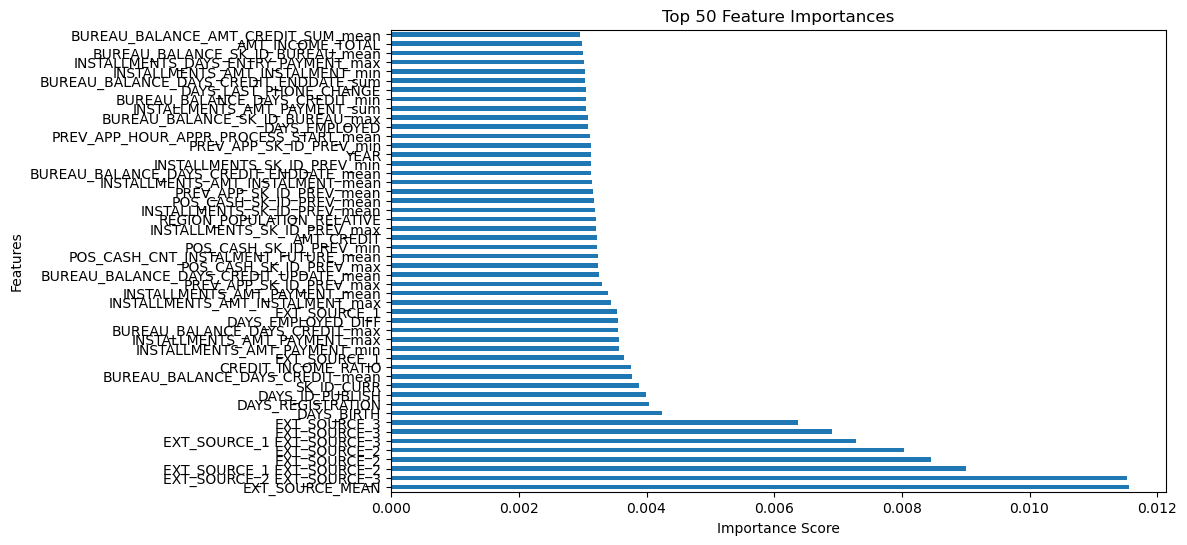

In [14]:
# Select important features using RandomForestClassifier
X = application_train.drop(columns=['TARGET'])
y = application_train['TARGET']
rf = RandomForestClassifier()
rf.fit(X, y)
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances.head(20))
plt.figure(figsize=(10, 6))
feature_importances.head(50).plot(kind='barh', title='Top 50 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


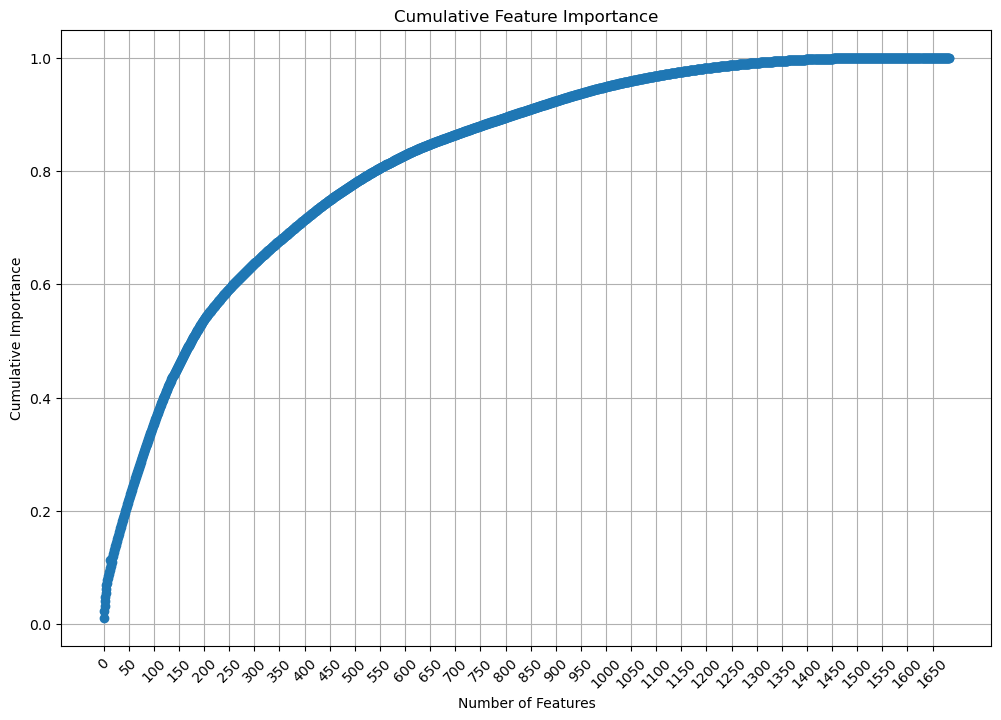

In [15]:
# Plot cumulative feature importance
cumulative_importance = feature_importances.cumsum()
plt.figure(figsize=(12, 8))
plt.plot(cumulative_importance, marker='o')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.grid(True)
num_features = len(cumulative_importance)
tick_positions = range(0, num_features, 50)
tick_labels = [str(i) for i in tick_positions]
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.show()


In [16]:
# Select top 200 features based on importance
selected_features = feature_importances.head(250).index
common_features = [feature for feature in selected_features if feature in application_test.columns]
common_features.append('TARGET')
X_train_selected = application_train[common_features]
common_features.remove('TARGET')
X_test_selected = application_test[common_features]
X_train_selected = X_train_selected.fillna(X_train_selected.mean())
X_test_selected = X_test_selected.fillna(X_test_selected.mean())
print('Shape of the final training dataset:', X_train_selected.shape)
print('Shape of the final test dataset:', X_test_selected.shape)


Shape of the final training dataset: (307511, 257)
Shape of the final test dataset: (48744, 256)


In [17]:
# Save the final training and test datasets to CSV files
X_train_selected.to_csv('final_application_train.csv', index=False)
X_test_selected.to_csv('final_application_test.csv', index=False)
print("Training and test datasets have been saved successfully.")


Training and test datasets have been saved successfully.
